# SMS Spam Detection

### Goals
	- Should detect spams from a stream of SMS
	- Should not delay messages
	- Must not classify any true SMS as spams

## DATA

### Data loading

In [1]:
# Seed for reproducibility
import random
seed = 1
random.seed(seed)

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def display_df(df):
    """
    Takes a DataFrame and displays it in a fine way.
    """
    with pd.option_context('display.max_colwidth', -1):
        display(df)

In [4]:
# Load the data + display first 10 lines
data = pd.read_csv("spam.csv", encoding="latin-1")
display_df(data.head(10))

v1  \
0  ham    
1  ham    
2  spam   
3  ham    
4  ham    
5  spam   
6  ham    
7  ham    
8  spam   
9  spam   

                                                                                                                                                                 v2  \
0  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...                                                    
1  Ok lar... Joking wif u oni...                                                                                                                                      
2  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's        
3  U dun say so early hor... U c already then say...                                                                                                                  
4  Nah I don't think he goes to usf, he lives around here though                                                                                                      
5  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv               
6  Even my brother is not like to speak with me. They treat me like aids patent.                                                                                      
7  As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune   
8  WINNER!! As a valued network customer you have been selected to receivea å£900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.     
9  Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030         

  Unnamed: 2 Unnamed: 3 Unnamed: 4  
0  NaN        NaN        NaN        
1  NaN        NaN        NaN        
2  NaN        NaN        NaN        
3  NaN        NaN        NaN        
4  NaN        NaN        NaN        
5  NaN        NaN        NaN        
6  NaN        NaN        NaN        
7  NaN        NaN        NaN        
8  NaN        NaN        NaN        
9  NaN        NaN        NaN

In [5]:
# Drops empty columns + rename them
data = data.drop(columns=data.columns[2:])
data.columns = ["label", "text"]

In [6]:
# Drop duplicated lines
print("Original dataframe : {} rows.".format(len(data)))
print("Drop duplicates dataframe : {} rows.".format(len(data.drop_duplicates())))
data = data.drop_duplicates()

Original dataframe : 5572 rows.
Drop duplicates dataframe : 5169 rows.


In [7]:
# Shuffle dataframe just in case
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)

### Looking into the data

In [8]:
# Several "ham" messages
ham_data = data[data["label"] == "ham"]
display_df(ham_data.head(10))

label  \
0   ham    
1   ham    
2   ham    
4   ham    
5   ham    
6   ham    
7   ham    
8   ham    
9   ham    
10  ham    

                                                                                                                                                           text  
0   I've been barred from all B and Q stores for life!?This twat in orange dungerees came up to me and asked if I wanted decking? So I got the first punch in!!  
1   Gam gone after outstanding innings.                                                                                                                          
2   Am okay. Will soon be over. All the best                                                                                                                     
4   Alrite jod hows the revision goin? Keris bin doin a smidgin. N e way u wanna cum over after college?xx                                                       
5   Dear got train and seat mine lower seat                                                                                                                      
6   I'm a guy, browsin is compulsory                                                                                                                             
7   No management puzzeles.                                                                                                                                      
8   Probably, want to pick up more?                                                                                                                              
9   Jus finish bathing...                                                                                                                                        
10  I'm back &amp; we're packing the car now, I'll let you know if there's room

In [9]:
# Several "spam" messages
spam_data = data[data["label"] == "spam"]
display_df(spam_data.head(10))

label  \
3   spam   
24  spam   
29  spam   
35  spam   
42  spam   
60  spam   
67  spam   
80  spam   
88  spam   
94  spam   

                                                                                                                                                                   text  
3   Welcome! Please reply with your AGE and GENDER to begin. e.g 24M                                                                                                     
24  HOT LIVE FANTASIES call now 08707500020 Just 20p per min NTT Ltd, PO Box 1327 Croydon CR9 5WB 0870 is a national rate call                                           
29  Urgent Please call 09066612661 from landline. å£5000 cash or a luxury 4* Canary Islands Holiday await collection. T&Cs SAE award. 20M12AQ. 150ppm. 16+ ÛÏ           
35  Talk sexy!! Make new friends or fall in love in the worlds most discreet text dating service. Just text VIP to 83110 and see who you could meet.                     
42  For your chance to WIN a FREE Bluetooth Headset then simply reply back with \ADP\""                                                                                  
60  <Forwarded from 448712404000>Please CALL 08712404000 immediately as there is an urgent message waiting for you.                                                      
67  WELL DONE! Your 4* Costa Del Sol Holiday or å£5000 await collection. Call 09050090044 Now toClaim. SAE, TCs, POBox334, Stockport, SK38xh, Costå£1.50/pm, Max10mins   
80  URGENT, IMPORTANT INFORMATION FOR O2 USER. TODAY IS YOUR LUCKY DAY! 2 FIND OUT WHY LOG ONTO HTTP://WWW.URAWINNER.COM THERE IS A FANTASTIC SURPRISE AWAITING FOR YOU  
88  This message is brought to you by GMW Ltd. and is not connected to the                                                                                               
94  tells u 2 call 09066358152 to claim å£5000 prize. U have 2 enter all ur mobile & personal details @ the prompts. Careful!

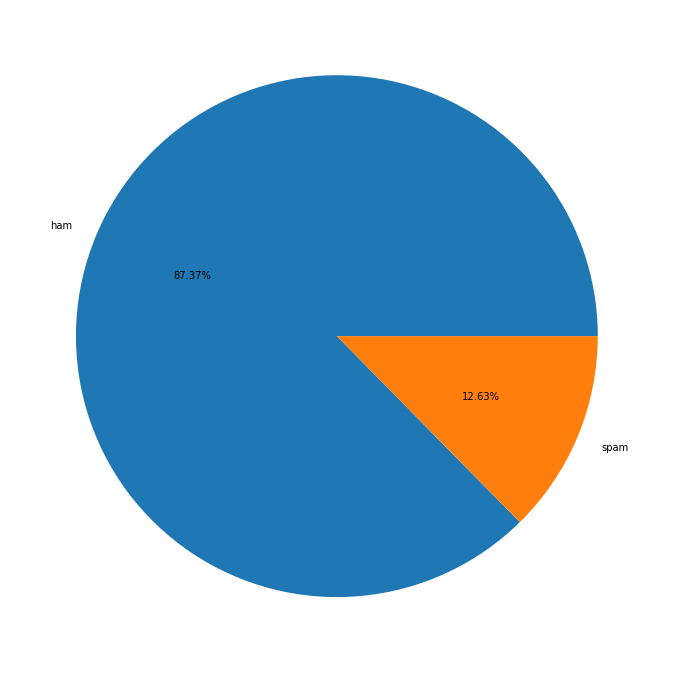

In [10]:
# Text messages sharing
counts = data["label"].value_counts()

fig1, ax1 = plt.subplots(figsize=(12,12))
ax1.pie(counts.values, labels=counts.index, autopct='%.2f%%')
plt.show()

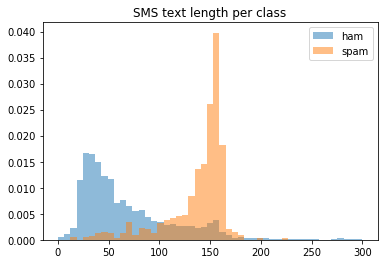

In [11]:
# SMS text length per class

def text_len_from_df(df):
    return [len(text) for text in df["text"]]

bins = np.linspace(0, 300, 50)
plt.hist(text_len_from_df(ham_data), bins, alpha=0.5, label='ham', density=True)
plt.hist(text_len_from_df(spam_data), bins, alpha=0.5, label='spam', density=True)
plt.legend(loc='upper right')
plt.title("SMS text length per class")
plt.show()

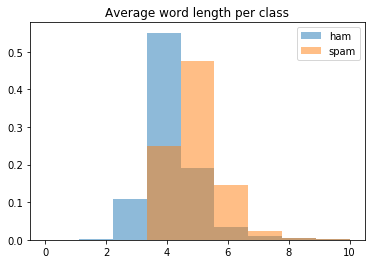

In [12]:
# Average word length per class

def word_len_from_df(df):
    return [np.mean([len(word) for word in text.split()]) for text in df["text"]]

bins = np.linspace(0, 10, 10)
plt.hist(word_len_from_df(ham_data), bins, alpha=0.5, label='ham', density=True)
plt.hist(word_len_from_df(spam_data), bins, alpha=0.5, label='spam', density=True)
plt.legend(loc='upper right')
plt.title("Average word length per class")
plt.show()

### Split data between train and test

In [13]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)
len(train), len(test)

(4135, 1034)

## Model training

### TF-IDF vectorizer (fit dictionary)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
    stop_words="english",
    strip_accents="unicode",
    analyzer="word",
    ngram_range=(1, 3),
    max_features=10000,
    lowercase=False,
)
char_vectorizer = TfidfVectorizer(
    stop_words="english",
    strip_accents="unicode",
    analyzer="char",
    ngram_range=(1, 5),
    max_features=10000,
    lowercase=False,
)

In [15]:
word_vectorizer.fit(train["text"])
char_vectorizer.fit(train["text"])

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 5), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [16]:
# Word dictionary
word_vectorizer.get_feature_names()

['00',
 '00 Sub',
 '00 Sub 16',
 '000',
 '000 Bonus',
 '000 Bonus Caller',
 '000 Xmas',
 '000 Xmas prize',
 '000 bonus',
 '000 bonus caller',
 '000 cash',
 '000 cash 000',
 '000 cash await',
 '000 prize',
 '000 prize To',
 '02',
 '02 06',
 '02 06 03',
 '02 09',
 '02 09 03',
 '0207',
 '0207 153',
 '03',
 '03 05',
 '03 2nd',
 '03 2nd attempt',
 '03 This',
 '03 This 2nd',
 '04',
 '05',
 '0578',
 '06',
 '06 03',
 '06 03 2nd',
 '06 03 This',
 '07',
 '07 11',
 '07 11 04',
 '07123456789',
 '07123456789 87077',
 '07123456789 87077 Yahoo',
 '07xxxxxxxxx',
 '07xxxxxxxxx won',
 '07xxxxxxxxx won 000',
 '08',
 '0800',
 '0800 542',
 '0800 542 0578',
 '08000407165',
 '08000407165 18',
 '08000407165 18 stop',
 '08000776320',
 '08000776320 reply',
 '08000776320 reply delivery',
 '08000839402',
 '08000839402 call2optout',
 '08000930705',
 '08000930705 delivery',
 '08000930705 delivery tomorrow',
 '08000938767',
 '08000938767 update',
 '08000938767 update or2stoptxt',
 '08001950382',
 '08001950382 Call2O

In [17]:
# Char-based dictionary
char_vectorizer.get_feature_names()

[' ',
 ' !',
 ' ! ',
 ' !!',
 ' &',
 ' & ',
 ' &a',
 ' &am',
 ' &amp',
 ' &l',
 ' &lt',
 ' &lt;',
 " '",
 ' (',
 ' *',
 ' * ',
 ' +',
 ' ,',
 ' , ',
 ' -',
 ' - ',
 ' .',
 ' . ',
 ' . .',
 ' . . ',
 ' . I',
 ' ..',
 ' ...',
 ' ... ',
 ' 0',
 ' 07',
 ' 08',
 ' 080',
 ' 0800',
 ' 087',
 ' 0870',
 ' 0871',
 ' 09',
 ' 090',
 ' 0905',
 ' 0906',
 ' 1',
 ' 1 ',
 ' 10',
 ' 11',
 ' 12',
 ' 15',
 ' 150',
 ' 150p',
 ' 16',
 ' 18',
 ' 1s',
 ' 1st',
 ' 1st ',
 ' 2',
 ' 2 ',
 ' 2 c',
 ' 2 g',
 ' 2 m',
 ' 2 s',
 ' 2 w',
 ' 20',
 ' 200',
 ' 2n',
 ' 2nd',
 ' 2nd ',
 ' 3',
 ' 3 ',
 ' 4',
 ' 4 ',
 ' 4 a',
 ' 4 m',
 ' 4*',
 ' 4* ',
 ' 5',
 ' 5 ',
 ' 50',
 ' 6',
 ' 6 ',
 ' 7',
 ' 8',
 ' 80',
 ' 800',
 ' 83',
 ' 86',
 ' 87',
 ' 9',
 ' :',
 ' :)',
 ' :-',
 ' :-)',
 ' ?',
 ' ? ',
 ' ? D',
 ' ? I',
 ' ? I ',
 ' ? W',
 ' A',
 ' A ',
 ' AN',
 ' AT',
 ' AT ',
 ' Ac',
 ' Acc',
 ' Al',
 ' An',
 ' And',
 ' And ',
 ' Any',
 ' Ar',
 ' Are',
 ' Are ',
 ' B',
 ' BA',
 ' BE',
 ' BO',
 ' BOX',
 ' Ba',
 ' Be',
 ' Bo',
 ' B

In [18]:
# Transform train dataset with both word-based and char-based dictionaries
X_train_words = word_vectorizer.transform(train["text"])
X_train_chars = char_vectorizer.transform(train["text"])
X_train = np.hstack([X_train_words, X_train_chars])
Y_train = train["label"]

# Transform test dataset with both word-based and char-based dictionaries
X_test_words = word_vectorizer.transform(test["text"])
X_test_chars = char_vectorizer.transform(test["text"])
X_test = np.hstack([X_test_words, X_test_chars])
Y_test = test["label"]

### Train classifiers

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [20]:
# Train words classifier
clf_words = SVC(kernel='linear', C = 1.0)
clf_words.fit(X_train_words, Y_train)
clf_words.score(X_test_words, Y_test)

0.9874274661508704

In [21]:
# Train chars classifier
clf_chars = SVC(kernel='linear', C = 1.0)
clf_chars.fit(X_train_chars, Y_train)
clf_chars.score(X_test_chars, Y_test)

0.9932301740812379

### Compute metrics

In [22]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import recall_score, precision_score, confusion_matrix

def compute_score(score_fun, y_true, y_pred):
    params = {
        "y_pred":y_pred,
        "y_true":y_true,
        "labels":["ham", "spam"],
        "pos_label":"spam",
    }
    return score_fun(**params)

def print_results(clf, X, y, title):
    y_pred = clf.predict(X)
    plot_confusion_matrix(y, y_pred, title=title)
    print("Recall : {}".format(compute_score(recall_score, y, y_pred)))
    print("Precision : {}".format(compute_score(precision_score, y, y_pred)))
    
def plot_confusion_matrix(y_true, y_pred, title="Confusion matrix", cmap=plt.cm.Blues):
    """
    Inspired by : https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "d"),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Recall : 0.926829268292683
Precision : 0.9661016949152542


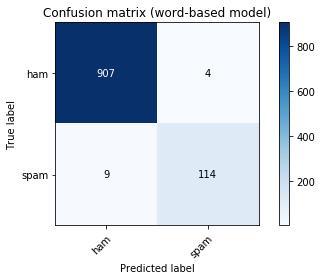

In [23]:
# Confusion matrix using word-based model
print_results(clf_words, X_test_words, Y_test, title="Confusion matrix (word-based model)")

Recall : 0.9512195121951219
Precision : 0.9915254237288136


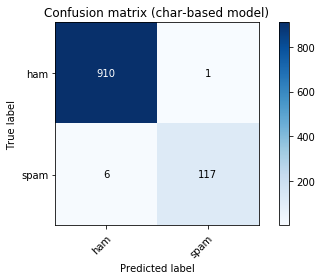

In [24]:
# Confusion matrix using char-based model
print_results(clf_chars, X_test_chars, Y_test, title="Confusion matrix (char-based model)")

### Getting more precision

In [25]:
# Train SVC classifier to output probabilities as well
clf_chars = SVC(kernel='linear', C = 1.0, probability=True)
clf_chars.fit(X_train_chars, Y_train)
clf_chars.score(X_test_chars, Y_test)

0.9932301740812379

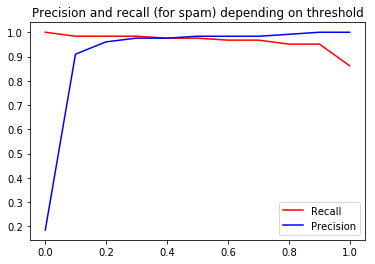

In [26]:
# Precision and recall for spam depending on threshold
probas = clf_chars.predict_proba(X_test_chars)
threshold_list = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.999]
recall_list = []
precision_list = []
for threshold in threshold_list :
    y_pred = ["spam" if b else "ham" for b in probas[:,1] >= threshold]
    recall_list.append(compute_score(recall_score, Y_test, y_pred))
    precision_list.append(compute_score(precision_score, Y_test, y_pred))

plt.plot(threshold_list, recall_list, 'r', label="Recall") # plotting t, a separately 
plt.plot(threshold_list, precision_list, 'b', label="Precision") # plotting t, b separately
plt.title("Precision and recall (for spam) depending on threshold")
plt.legend()
plt.show()

In [27]:
# Threshold to get 1.0 precision
print(threshold_list[-2])
print(precision_list[-2])
print(recall_list[-2])

0.9
1.0
0.9512195121951219


### What about timing ?

In [28]:
def predict(text):
    X = word_vectorizer.transform([text])
    return clf_chars.predict(X)[0]

def predict_batch(data):
    X = word_vectorizer.transform(data)
    return clf_chars.predict(X)

In [29]:
timeit predict("How are you today ? Is this a spam ?")

552 µs ± 5.69 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [30]:
timeit predict_batch(data["text"].head(1000))

137 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Visualize TF-IDF dictionary on real examples

In [31]:
# Credits : https://buhrmann.github.io/tfidf-analysis.html

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
def plot_tfidf_top_words(Xtr, y, features):
    plot_tfidf_classfeats_h(top_feats_by_class(Xtr, y, features))

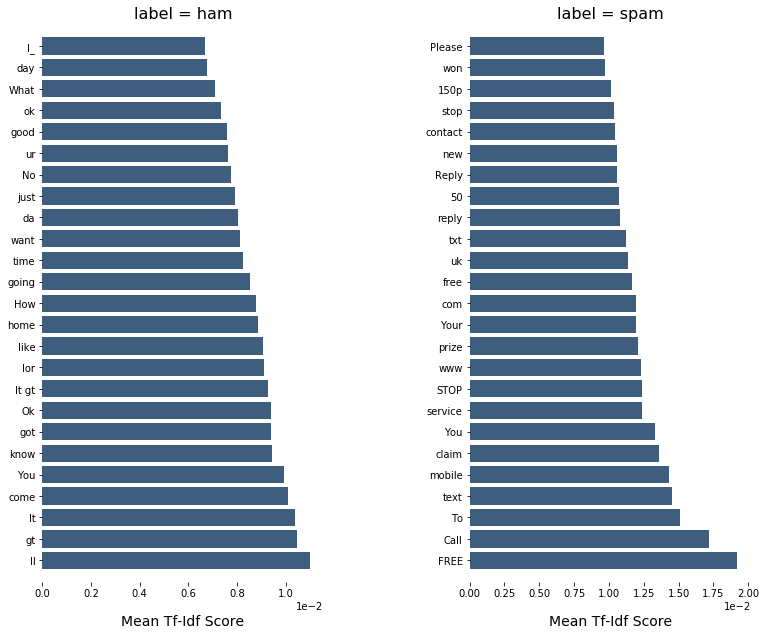

In [32]:
Xtr = X_train_words
y = Y_train
features = word_vectorizer.get_feature_names()

plot_tfidf_top_words(Xtr, y, features)